# Training UNet for drop segmentation

In [24]:
import torch
from checkpoints import *
from measures import *

In [46]:
config = {
    "lr": 0.0003,
    "batch_size": 16,
    "epochs": 3,
    "threshold": 0.3,
    "init_from_checkpoint": False,
    "image_dir": '../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7',
    "mask_dir": '../../data/derain/ALIGNED_PAIRS/CG_MASKS',
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint_dir": "cg_checkpoints",
    "checkpoint": "UNetAdamBCEt14v14e11.pt", # if None loads last saved checkpoint
    "print_model": False,
    "seed": 3407 # if None uses random seed
}
print(f"Training using {config['device']}")

Training using cuda


In [40]:
# Set seed
if config["seed"] is not None:
    torch.manual_seed(config["seed"])  

In [41]:
# Load train and val datasets and prepare loaders

from torch.utils.data import DataLoader
import importlib
import dataset
importlib.reload(dataset)
from dataset import WaterDropDataset
dataset = WaterDropDataset(
    image_dir=config["image_dir"],
    mask_dir=config["mask_dir"],
    threshold=config["threshold"],
    crop_shape=(256, 256)
)

assert dataset, "Dataset is empty!"

train_dataset, val_dataset = dataset.random_split(0.1)
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)

print (f'Loaded {len(dataset)} images\n')
print (f'Train: {len(train_dataset)} images, {len(train_loader)} batches')
print (f'Val: {len(val_dataset)} images, {len(val_loader)} batches')

Loaded 4812 images

Train: 4331 images, 271 batches
Val: 481 images, 31 batches


In [42]:
# Load model, loss function and optimizer
from torch import nn
from unet import UNet
from unet import init_weights
from pathlib import Path

model = UNet(5).to(config['device'])

# Load or fill weights
# And set the start_epoch of model
if config["init_from_checkpoint"]:
    if config["checkpoint"] is None:
        path = last_checkpoint(config["checkpoint_dir"])
    else:
        path = Path(config["checkpoint_dir"], config["checkpoint"])     
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Loaded parameters from '{path}'")
    print_checkpoint(checkpoint)
    start_epoch = checkpoint["epochs"]
else:
    init_weights(model, torch.nn.init.normal_, mean=0., std=1)
    print("Randomly initiated parameters")
    start_epoch = 0

# Set optimizer & loss_fn
optimizer = torch.optim.Adam(params=model.parameters(), lr=config['lr'])

loss_fn = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

layers = model.train()
if config["print_model"]:
    print(layers)

Randomly initiated parameters


In [43]:
def check_accuracy_and_save(model, optimizer, loss_fn, epoch, train_loss, save=True):
    model.eval()

    losses = []
    accuracies = []
    precisions = []
    recalls = []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(config['device'])
            y = y.to(config['device'])

            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            
            pred = torch.sigmoid(model(x))
            pred = pred.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            
            accuracies.append(accuracy(y, pred))
            precisions.append(precision(y, pred))
            recalls.append(recall(y, pred))
            
    mean = lambda l: sum(l) / len(l)
    mean_loss = mean(losses)
    print("Valid loss:", mean_loss, '\n')
    print("Accuracy: ", mean(accuracies))
    print("Precision:", mean(precisions))
    print("Recall:   ", mean(recalls), '\n')
    model.train()

    if save:
        save_checkpoint(
            config["checkpoint_dir"],
            model,
            optimizer,
            loss_fn,
            epoch,
            train_loss,
            mean_loss
        )

In [44]:
from tqdm.notebook import tqdm
from sys import stdout
def train(save_checkpoints=True):
    for epoch in range(config['epochs']):
        epoch += start_epoch
        print("Epoch", epoch)
        
        loader = tqdm(train_loader)
        losses = []
        
        for image, gt in loader:
            image = image.to(config['device'])
            gt = gt.float().to(config['device'])
            with torch.cuda.amp.autocast():
                pred = model(image)
                loss = loss_fn(pred, gt)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss = loss.item()
            losses.append(train_loss)
            loader.set_postfix(loss=train_loss)

        mean_loss = sum(losses) / len(losses)
        print("Train loss:", mean_loss)
        check_accuracy_and_save(
            model, 
            optimizer,
            loss_fn,
            epoch, 
            mean_loss,
            save=save_checkpoints
        )

In [56]:
train(save_checkpoints=True)
start_epoch = start_epoch + config["epochs"]

Epoch 0


  0%|          | 0/271 [00:00<?, ?it/s]

Train loss: 0.5578576171310186
Valid loss: 0.576377937870641 

Accuracy:  0.8036623478176133
Precision: 0.7090107663684795
Recall:    0.5796372652534516 

Progress saved to 'cg_checkpoints/UNetAdamBCEt55v57e0.pt'
Epoch 1


  0%|          | 0/271 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Estimation

In [57]:
def predict(model, x, y, binary_map=True, binary_threshold=0.4):
    image_np = x.detach().numpy()[0]
    gt_np = y.detach().numpy()[0][0]

    model.eval()
    with torch.no_grad():
        x = x.to(config['device'])
        y = y.to(config['device'])

        pred = torch.sigmoid(model(x))
    model.train()
    pred_np  = pred.cpu().detach().numpy()[0][0]
    if binary_map:
        pred_np = pred_np >= binary_threshold
    return image_np, gt_np, pred_np

In [58]:
def plot_prediction(x, y, binary_map=True, binary_threshold=0.42):
    x = torch.stack([x])
    y = torch.stack([y])
    x, y, pred = predict(model, x, y, binary_map, binary_threshold)
    print("Accuracy: ", accuracy([y], [pred]))
    print("Precision:", precision([y], [pred]))
    print("Recall:   ", recall([y], [pred]))
    
    from matplotlib import pyplot as plt
    from PIL import Image
    import numpy as np

    sat = x[3]
    
    fig, axs = plt.subplots(1, 3, figsize=(17, 10))
    img = np.transpose(x[:3], (1, 2, 0))
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(y, cmap='gray')
    axs[2].imshow(pred, cmap='gray')

Index: 247
Accuracy:  0.7981188297271729
Precision: 0.6971660852432251
Recall:    0.5882641077041626


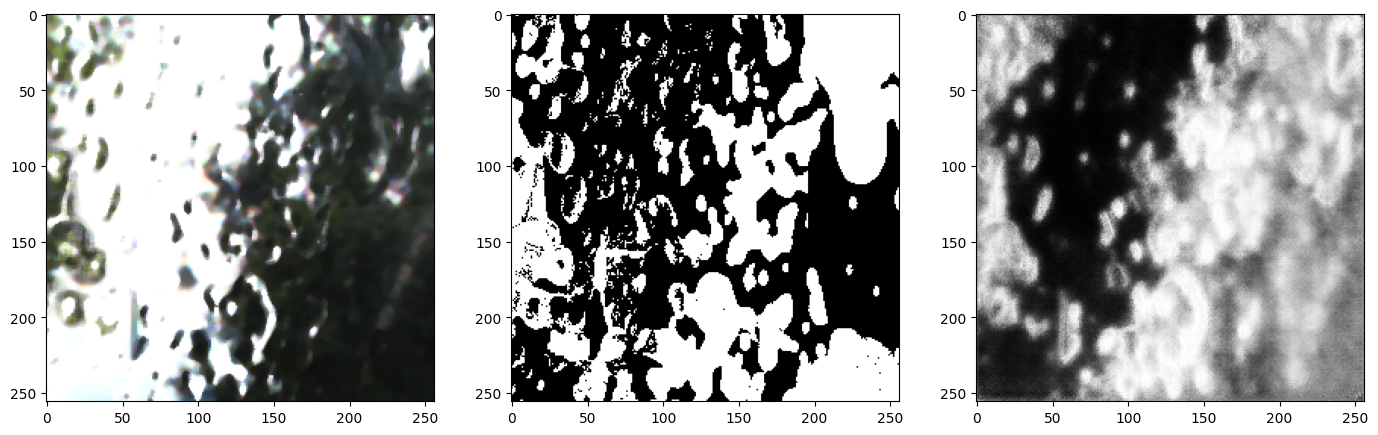

In [61]:
# Get prediction for random image and crop
from random import randint
idx = randint(0, len(val_dataset)-1)
print("Index:", idx)
x, y = val_dataset[idx]
plot_prediction(x, y, binary_map=False)

Accuracy:  0.615441083908081
Precision: 0.8911396861076355
Recall:    0.020755715668201447


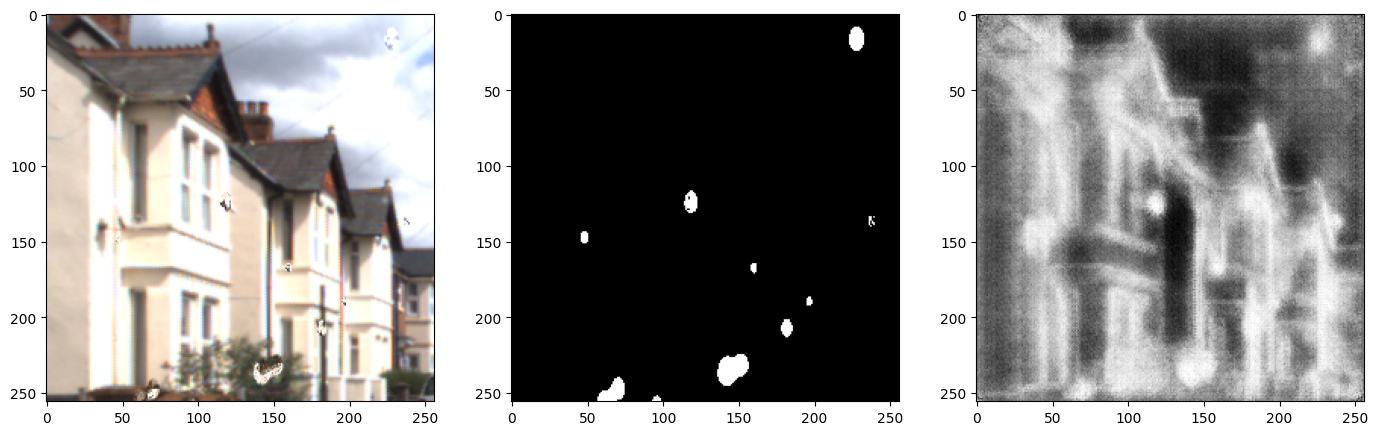

In [55]:
# Get prediction from opened image
image_path = "../../data/derain/ALIGNED_PAIRS/CG_DROPLETS/left_1535201264389466.png"
mask_path = "../../data/derain/ALIGNED_PAIRS/CG_MASKS/left_1535201264389466.png"
from PIL import Image, ImageFilter
image = Image.open(image_path)
mask  = Image.open(mask_path)
x, y = dataset.transform(image, mask)
plot_prediction(x, y, binary_map=False)

In [190]:
# Clear checkpoints by condition
#clear_checkpoints(config["checkpoint_dir"], condition=lambda ch: ch["val_loss"] >= 0.15, save_last=3)

In [18]:
!ls -la cg_checkpoints

total 1455540
drwxrwsr-x 2 kondrashov students      4096 Aug  8 20:17 .
drwxrwsr-x 6 kondrashov students      4096 Aug  9 13:02 ..
-rw-rw-r-- 1 kondrashov students 372610293 Aug  8 20:24 UNetAdamBCEt68v67e2.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  8 20:21 UNetAdamBCEt68v68e1.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  8 19:32 UNetAdamBCEt82v68e0.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  8 20:17 UNetAdamBCEt94v68e0.pt


In [22]:
def modify_dataset():
    # Modify images to make them smoother
    save_dir = '../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7'
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    step = 1
    for path in Path(config["image_dir"]).glob('*.png'):
        image = Image.open(path)
        image = image.filter(ImageFilter.MedianFilter(size = 5))
        new_path = Path(save_dir, path.name)
        image.save(new_path)
        print("Saved", new_path, step)
        step = step + 1

In [23]:
modify_dataset()

Saved ../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7/left_1535205099295265.png 1
Saved ../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7/left_1535204288814221.png 2
Saved ../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7/left_1535201988046113.png 3
Saved ../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7/left_1535201405685392.png 4
Saved ../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7/left_1535205078706784.png 5
Saved ../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7/left_1535204265284413.png 6
Saved ../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7/left_1535203065001231.png 7
Saved ../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7/left_1535201304978232.png 8
Saved ../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7/left_1535201962751663.png 9
Saved ../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7/left_1535202540994470.png 10
Saved ../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7/left_1535202956764574.png 11
Saved ../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7/left_1535204764820501.png 12
Saved ../../data/derain/A